이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

이 노트북은 텐서플로 2.9 버전에서 테스트했습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter12_part02_deep-dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 딥드림

### 케라스 딥드림 구현

**테스트 이미지 다운로드하기**

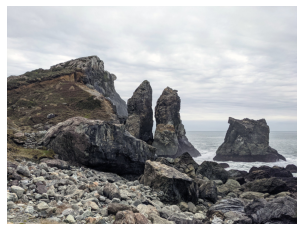

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

**사전 훈련된 `InceptionV3` 모델 로드하기**

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

2022-06-01 13:15:04.065537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**딥드림 손실에 대한 각 층의 기여도 설정하기**

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**딥드림 손실**

In [4]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

**딥드림 경사 상승법 단계**

In [5]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... 스텝 {i}에서 손실 값: {loss:.2f}")
    return image

In [6]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

**이미지 처리 유틸리티**

In [7]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img += 1.0
    img *= 127.5
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**연속적인 여러 개의 “옥타브"에 걸쳐 경사 상승법 실행하기**

In [8]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"{shape} 크기의 {i}번째 옥타브 처리")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

(459, 612) 크기의 0번째 옥타브 처리
... 스텝 0에서 손실 값: 0.80
... 스텝 1에서 손실 값: 1.07
... 스텝 2에서 손실 값: 1.44
... 스텝 3에서 손실 값: 1.82
... 스텝 4에서 손실 값: 2.16
... 스텝 5에서 손실 값: 2.52
... 스텝 6에서 손실 값: 2.84
... 스텝 7에서 손실 값: 3.22
... 스텝 8에서 손실 값: 3.55
... 스텝 9에서 손실 값: 3.90
... 스텝 10에서 손실 값: 4.30
... 스텝 11에서 손실 값: 4.65
... 스텝 12에서 손실 값: 5.00
... 스텝 13에서 손실 값: 5.35
... 스텝 14에서 손실 값: 5.72
... 스텝 15에서 손실 값: 6.09
... 스텝 16에서 손실 값: 6.44
... 스텝 17에서 손실 값: 6.79
... 스텝 18에서 손실 값: 7.12
... 스텝 19에서 손실 값: 7.46
... 스텝 20에서 손실 값: 7.75
... 스텝 21에서 손실 값: 8.10
... 스텝 22에서 손실 값: 8.38
... 스텝 23에서 손실 값: 8.71
... 스텝 24에서 손실 값: 9.01
... 스텝 25에서 손실 값: 9.25
... 스텝 26에서 손실 값: 9.59
... 스텝 27에서 손실 값: 9.83
... 스텝 28에서 손실 값: 10.13
... 스텝 29에서 손실 값: 10.40
(642, 857) 크기의 1번째 옥타브 처리
... 스텝 0에서 손실 값: 1.61
... 스텝 1에서 손실 값: 2.66
... 스텝 2에서 손실 값: 3.45
... 스텝 3에서 손실 값: 4.03
... 스텝 4에서 손실 값: 4.56
... 스텝 5에서 손실 값: 5.03
... 스텝 6에서 손실 값: 5.51
... 스텝 7에서 손실 값: 5.91
... 스텝 8에서 손실 값: 6.31
... 스텝 9에서 손실 값: 6.67
... 스텝 10에서 손실 값: 7.04
... 스텝 11에서 손실 값: 7.36


![dream.png](dream.png)

### 정리